In [1]:
# google colab で実行する場合は以下のコメントアウトを外す
# ! wget https://github.com/KHiraGit/sudspg_ds/raw/main/ds09_icecream.xlsx
# ! pip install pmdarima

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm

In [2]:
# アイスクリームの売上データ 
# https://www.icecream.or.jp/iceworld/data/expenditures.html
icecream_df = pd.read_excel('ds09_icecream.xlsx', index_col=0)

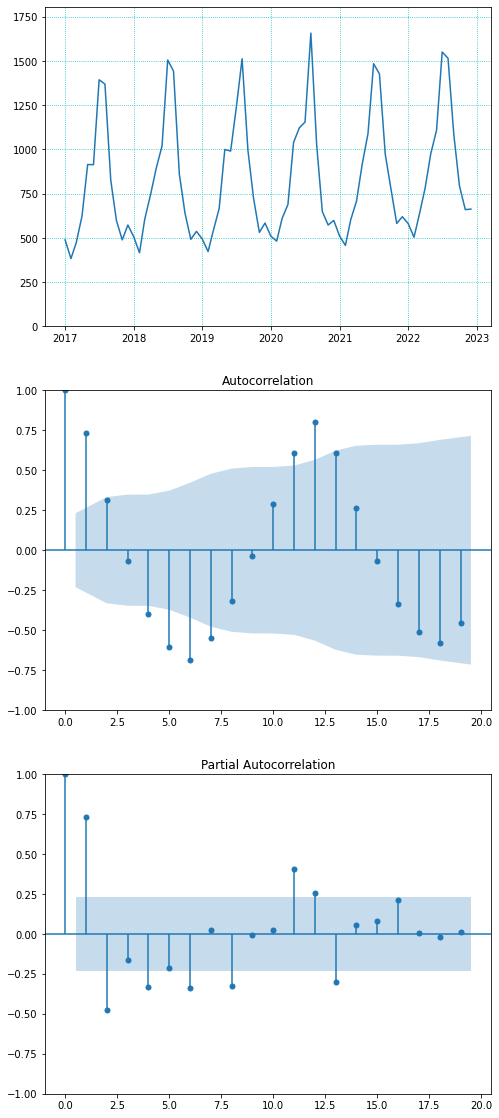

In [3]:
# アイスクリーム売上のグラフを表示
fig = plt.figure(figsize=(8, 20))  
ax = fig.add_subplot(311)
ax.plot(icecream_df)
y_min, y_max = ax.get_ylim()
ax.set_ylim(0, y_max * 1.05)
ax.grid(axis='both',linestyle='dotted', color='c')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# 自己相関係数と偏自己相関係数のグラフを表示
ax1 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_acf(icecream_df, ax=ax1)
ax2 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(icecream_df, ax=ax2, method='ywm')

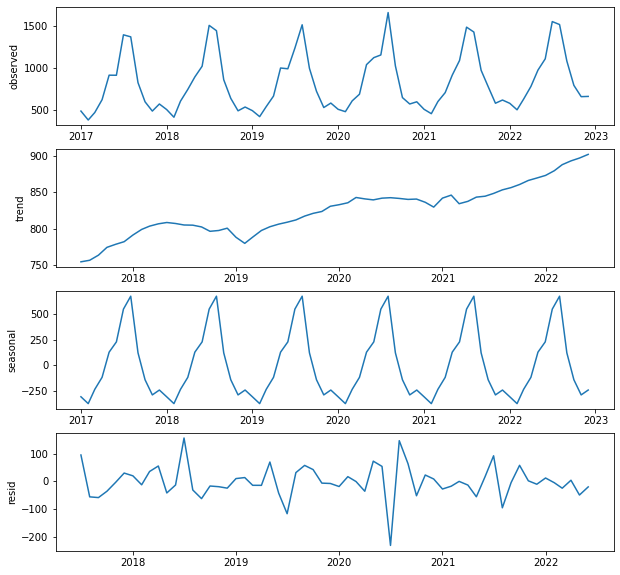

In [4]:
# 時系列データをトレンド、規則的変動成分、不規則変動成分に分解
res = sm.tsa.seasonal_decompose(icecream_df, period=12)
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(411)
ax1.set_ylabel('observed')
ax1.plot(res.observed)
ax2 = fig.add_subplot(412)
ax2.set_ylabel('trend')
ax2.plot(res.trend)
ax3 = fig.add_subplot(413)
ax3.set_ylabel('seasonal')
ax3.plot(res.seasonal)
ax4 = fig.add_subplot(414)
ax4.set_ylabel('resid')
ax4.plot(res.resid)


In [5]:
# モデル構築と検証のためのデータを準備
train = icecream_df[0:60]  # 学習用データ 2021年まで
test = icecream_df[60:]  # 検証用データ 2022年分

In [7]:
from pmdarima import auto_arima
from warnings import simplefilter
simplefilter("ignore", FutureWarning)  # FutureWarningを無視する

stepwise_fit = auto_arima(train, seasonal=True, trace=True, m=12, stepwise=True)                         
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=577.809, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=575.012, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=578.501, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=578.794, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=570.049, Time=0.53 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=568.852, Time=0.35 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=574.819, Time=0.09 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=569.671, Time=0.46 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=0.90

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -280.426
Date:                  Tue, 03 Jun 2025   AIC                            568.852
Time:                          10:11:42   BIC                            576.337
Sample:                      01-01-2017   HQIC                           571.681
                           - 12-01-2021                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     44.2820     15.138      2.925      0.003      14.613      73.951
ar.S.L12      -0.4606      0.093     -4.970      0.000      -0.642      -0.279
ar.S.L24      -0.5065      0.141     -3.581      0.000      -0.784      -0.229
sigma2      5847.6377   1216.130      4.808      0.000    3464.066    8231.209
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                 6.31
Prob(Q):                              0.38   Prob(JB):                         0.04
Heteroskedasticity (H):               2.05   Skew:                            -0.67
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

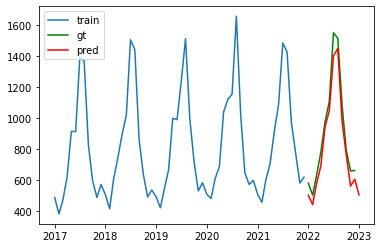

In [8]:
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
SARIMA = sm.tsa.SARIMAX(train.earning, order=(0, 0, 0), seasonal_order=(2, 1, 0, 12)).fit()
pred = SARIMA.predict('2022-01-01', '2023-01-01')
# 実データと予測結果の図示
plt.plot(train.earning, label="train")
plt.plot(test.earning, "g", label="gt")
plt.plot(pred, "r", label="pred")
plt.legend()